<a href="https://colab.research.google.com/github/kate-somi/kate-somi.github.io/blob/master/HSE_ML_team1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libs and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install haversine

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn import metrics

from haversine import haversine

In [ ]:
PATH = 'drive/MyDrive/HSE_ML_team1'

train = pd.read_csv(PATH + '/train.csv', nrows=2_500_000)
test = pd.read_csv(PATH + '/test.csv')
train.name = 'Train'
test.name = 'Test'

EDA

In [ ]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 152.6+ MB


In [ ]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.500000e+06,2.500000e+06,2.500000e+06,2.499981e+06,2.499981e+06,2.500000e+06
mean,1.134467e+01,-7.251697e+01,3.992710e+01,-7.251614e+01,3.992419e+01,1.684222e+00
std,9.838472e+00,1.286145e+01,8.343414e+00,1.267979e+01,1.007531e+01,1.326494e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399139e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396712e+01,4.076711e+01,-7.396368e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.912465e+03,3.414307e+03,3.345917e+03,2.080000e+02


In [ ]:
train.corr()['fare_amount'].sort_values(ascending=False)

fare_amount          1.000000
passenger_count      0.012751
dropoff_longitude    0.008877
pickup_longitude     0.008120
dropoff_latitude    -0.005669
pickup_latitude     -0.007341
Name: fare_amount, dtype: float64

In [ ]:
train.isna().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    19
dropoff_latitude     19
passenger_count       0
dtype: int64

In [ ]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [ ]:
test.isna().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [ ]:
train[train.fare_amount <= 0].shape

(163, 8)

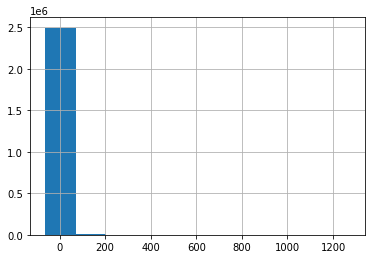

In [ ]:
train.fare_amount.hist()

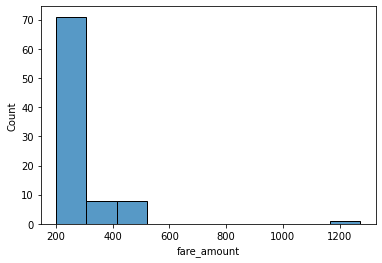

In [ ]:
to_plot = train[train['fare_amount'] > 200]
sns.histplot(x='fare_amount', data=to_plot, bins=10)

In [ ]:
train.passenger_count.value_counts()

1      1729478
2       369359
5       176901
3       109616
4        53202
6        52594
0         8846
208          3
9            1
Name: passenger_count, dtype: int64

In [ ]:
test.passenger_count.value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

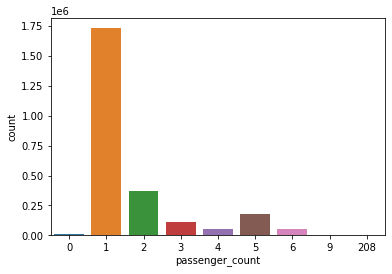

In [ ]:
sns.countplot(x='passenger_count', data=train)

In [ ]:
data_sets = [train, test]
coords_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
extr_vals = {'Train':{}, 'Test':{}}

for coord in coords_cols:
    for data_set in data_sets:
        extr_vals[data_set.name][coord+'_range'] = []
        extr_vals[data_set.name][coord+'_range'].append(data_set[coord].min())
        extr_vals[data_set.name][coord+'_range'].append(data_set[coord].max())
del data_sets

pd.DataFrame.from_dict(extr_vals)

,Train,Test
pickup_latitude_range,"[-3458.6647020000005, 2912.464657]","[40.573143, 41.709555]"
pickup_longitude_range,"[-3377.6809350000003, 2856.44156]","[-74.252193, -72.986532]"
dropoff_latitude_range,"[-3461.540872, 3345.9173530000003]","[40.568973, 41.696683]"
dropoff_longitude_range,"[-3383.2966079999997, 3414.306675]","[-74.263242, -72.990963]"


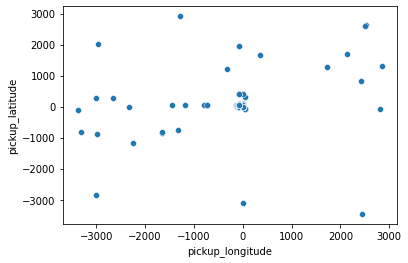

In [ ]:
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=train)

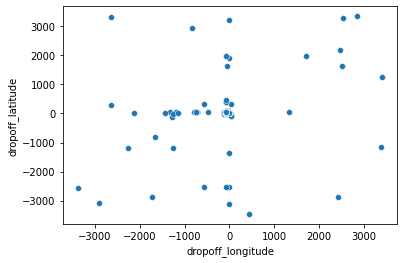

In [ ]:
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=train)

In [ ]:
coordinates = {'min_long': min(test.pickup_longitude.min(), test.dropoff_longitude.min()),
              'max_long': max(test.pickup_longitude.max(), test.dropoff_longitude.max()),
              'min_lat': min(test.pickup_latitude.min(), test.dropoff_latitude.min()),
              'max_lat' : min(test.pickup_latitude.max(), test.dropoff_latitude.max())}

In [ ]:
# limiting the axes while plotting to get a better observation of the data
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

(-74.03, -73.75)

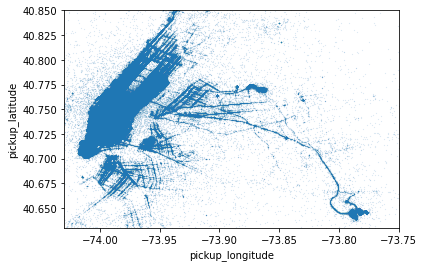

In [ ]:
train[(train.pickup_longitude >= coordinates['min_long']) & 
      (train.pickup_longitude <= coordinates['max_long']) & 
      (train.pickup_latitude >= coordinates['min_lat']) & 
      (train.pickup_latitude <= coordinates['max_lat']) &
      (train.dropoff_longitude >= coordinates['min_long']) &
      (train.dropoff_longitude <= coordinates['max_long']) &
      (train.dropoff_latitude >= coordinates['min_lat']) & 
      (train.dropoff_latitude<= coordinates['max_lat'])].plot(
        kind ='scatter', x='pickup_longitude', y='pickup_latitude', s=.02, alpha=0.4)

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Data cleaning

In [ ]:
train.dropna(inplace=True)

train = train[(train.fare_amount > 0) & (train.fare_amount < 150)]
train = train[(train.passenger_count > 0) & (train.passenger_count <= 6)]

train = train[(train.pickup_longitude >= coordinates['min_long']) &
              (train.pickup_longitude <= coordinates['max_long'])]
train = train[(train.pickup_latitude >= coordinates['min_lat']) &
              (train.pickup_latitude <= coordinates['max_lat'])]
train = train[(train.dropoff_longitude >= coordinates['min_long']) &
              (train.dropoff_longitude <= coordinates['max_long'])]
train = train[(train.dropoff_latitude >= coordinates['min_lat']) &
              (train.dropoff_latitude <= coordinates['max_lat'])]

Feature Engineering

In [ ]:
def add_features(df):
        df.drop(['pickup_datetime'], axis=1, inplace=True)
        df['key'] = pd.to_datetime(df.key, format="%Y-%m-%d %H:%M:%S")
        df['year'] = df.key.dt.year
        df['month'] = df.key.dt.month
        df['day'] = df.key.dt.day
        df['hour'] = df.key.dt.hour
        df['weekday'] = df.key.dt.weekday

        df['distance'] = df.apply(lambda row: np.round(haversine((row['pickup_latitude'],
                                                         row['pickup_longitude']),
                                                        (row['dropoff_latitude'],
                                                         row['dropoff_longitude'])), 3), 
                                                         axis=1)
        df['diff_lat'] = np.round(abs(df.pickup_latitude - df.dropoff_latitude), 3)
        df['diff_long'] = np.round(abs(df.pickup_longitude - df.dropoff_longitude), 3)

        return df

Normalization

In [ ]:
def normalize(df):
        df = pd.get_dummies(df, columns=['weekday'], drop_first=True)

        df.year -= df.year.min()
        df.year = np.round(df.year/df.year.max(), 3)

        df['month_sin'] = np.round(np.sin(2*np.pi*(df.month - 1)/12), 3)
        df['month_cos'] = np.round(np.cos(2*np.pi*(df.month - 1)/12), 3)

        df['day_sin'] = np.round(np.sin(2*np.pi*(df.day - 1)/31), 3)
        df['day_cos'] = np.round(np.cos(2*np.pi*(df.day - 1)/31), 3)

        df['hour_sin'] = np.round(np.sin(2*np.pi*(df.hour - 1)/24), 3)
        df['hour_cos'] = np.round(np.cos(2*np.pi*(df.hour - 1)/24), 3)

        df.pickup_latitude = np.round(coordinates['max_lat'] - df.pickup_latitude, 3)
        df.dropoff_latitude = np.round(coordinates['max_lat'] - df.dropoff_latitude, 3)
        df.pickup_longitude = np.round(coordinates['max_long'] - df.pickup_longitude, 3)
        df.dropoff_longitude = np.round(coordinates['max_long'] - df.dropoff_longitude, 3)

        df.drop(['month', 'day', 'hour'], axis=1, inplace=True)

        return df

Data Processing

In [ ]:
train = add_features(train)
train = normalize(train)

test = add_features(test)
test = normalize(test)

In [ ]:
X_train = train.drop(['fare_amount', 'key'], axis=1)
y_train = train.fare_amount

X_test = test.drop('key', axis=1)

In [ ]:
X_train

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,distance,diff_lat,diff_long,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,0.858,0.975,0.855,0.984,1,0.000,1.031,0.009,0.003,0,0,0,0,0,0,0.500,-0.866,0.299,-0.954,-0.866,-0.500
1,1.030,0.985,0.993,0.915,1,0.167,8.450,0.071,0.037,1,0,0,0,0,0,0.000,1.000,0.725,0.689,-0.707,-0.707
2,0.996,0.935,1.005,0.946,2,0.333,1.390,0.011,0.009,0,0,1,0,0,0,-0.500,-0.866,-0.299,-0.954,-0.259,0.966
3,1.001,0.964,1.005,0.939,1,0.500,2.799,0.025,0.004,0,0,0,0,1,0,1.000,0.000,-0.791,-0.612,0.707,0.707
4,0.982,0.929,0.970,0.913,1,0.167,1.999,0.016,0.011,1,0,0,0,0,0,0.866,0.500,0.999,-0.051,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499995,0.982,0.943,0.965,1.007,1,0.500,7.353,0.065,0.018,0,0,0,1,0,0,-0.866,-0.500,0.485,-0.874,-0.500,0.866
2499996,0.999,0.958,0.996,0.928,1,0.000,3.389,0.030,0.003,0,1,0,0,0,0,-0.866,-0.500,0.999,-0.051,1.000,0.000
2499997,0.994,0.931,1.014,0.968,1,0.000,4.427,0.037,0.020,1,0,0,0,0,0,-1.000,-0.000,-0.849,0.529,-1.000,-0.000
2499998,0.998,0.937,0.952,0.894,2,0.167,6.120,0.043,0.045,0,0,0,0,1,0,0.866,-0.500,-0.571,0.821,-0.707,0.707


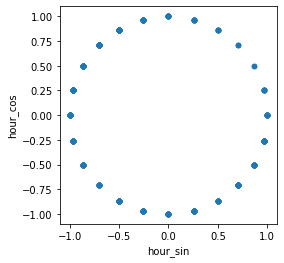

In [ ]:
# encoded cyclical features
X_train.sample(500).plot.scatter('hour_sin','hour_cos').set_aspect('equal')

Training and Predictions

In [ ]:
# try N1 -- 2_500_000 lines
# RMSE: 5.002
"""
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size=0.01)

lr = LinearRegression() 
lr.fit(Xtrain, ytrain)
lr.score(Xtest, ytest) # r2
"""

0.7274903958939682

In [ ]:
"""
predictions = lr.predict(X_test)
"""

In [ ]:
# try N2 -- 200_000 lines
# best params: C = 10
# RMSE: 4.39
"""
params = {'C': np.logspace(-3, 1, 20)}

svr = SVR(kernel='linear')

gs_svr = GridSearchCV(svr, params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs_svr.fit(X_train, labels)

best_model = gs_svr.best_estimator_
gs_svr.best_params_
"""

In [ ]:
# try N3 -- 1_000_000 lines
# best params: max_features = 6, n_estimators = 50
# RMSE: 3.23
"""
param_grid = [
    {'n_estimators': [3, 10, 30, 40, 50], 'max_features': [2, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score=True, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
grid_search.best_params_
"""

In [ ]:
"""
predictions = best_model.predict(X_test)
"""

In [ ]:
# try N4 -- 2_500_000 lines
# RMSE: 3.162
"""
forest_reg = RandomForestRegressor(max_features=6, n_estimators=50)
forest_reg.fit(X_train, y_train)

predictions = forest_reg.predict(X_test)
"""

In [ ]:
def modelfit(alg, Xtrain, Xtest, ytrain, useTrainCV=True, cv_folds=5, \
             early_stopping_rounds=50, predict=False):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(Xtrain, label=ytrain)
        xgtest = xgb.DMatrix(Xtest)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds, metrics='rmse',
                          early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(Xtrain, ytrain, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(Xtrain)
        
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % metrics.mean_squared_error(ytrain, dtrain_predictions, squared=False))
    
    #Predict on testing data:
    dtest_predictions = alg.predict(Xtest)
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    if predict:
        return dtest_predictions

In [ ]:
# try 5 -- 1_000_000 lines, disturbed
# best before interruption: [1118]	train-rmse:2.83293+0.00504668	test-rmse:3.41815+0.0306523
"""
xgb3 = XGBRegressor(
        learning_rate=0.15,
        n_estimators=1500,
        max_depth = 6,
        min_child_weight=5,
        gamma = 0.6,
        subsample = 1,
        colsample_bytree=0.9,
        reg_alpha=100,
        objective= 'reg:squarederror',
        nthread=6,
        scale_pos_weight=1,
        seed=27)

preds = modelfit(xgb3, X_train, X_test, y_train, predict=True)
"""

In [ ]:
# try 6 -- 100_000 lines, fewer features
# RMSE: 3.48
X_train = train.drop(['fare_amount', 'key', 'passenger_count',
                      'year', 'month_sin', 'month_cos',
                      'hour_sin', 'hour_cos', 'day_sin', 'day_cos'], axis=1)
y_train = train.fare_amount

X_test = test.drop(['key', 'passenger_count',
                    'year', 'month_sin', 'month_cos',
                    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'], axis=1)

[0]	train-rmse:12.4374+0.0129972	test-rmse:12.4386+0.0572105
[1]	train-rmse:10.8032+0.0129051	test-rmse:10.8059+0.055282
[2]	train-rmse:9.44363+0.0107763	test-rmse:9.44835+0.0559621
[3]	train-rmse:8.3188+0.0101465	test-rmse:8.3258+0.0546288
[4]	train-rmse:7.40445+0.00583173	test-rmse:7.4151+0.0672189
[5]	train-rmse:6.65499+0.00525891	test-rmse:6.66781+0.0622146
[6]	train-rmse:6.052+0.00420119	test-rmse:6.06787+0.0611458
[7]	train-rmse:5.57098+0.00229554	test-rmse:5.59103+0.0596767
[8]	train-rmse:5.19219+0.00245267	test-rmse:5.21567+0.0601858
[9]	train-rmse:4.89774+0.0064279	test-rmse:4.9244+0.0544734
[10]	train-rmse:4.66707+0.00758324	test-rmse:4.69688+0.051416
[11]	train-rmse:4.49127+0.00765649	test-rmse:4.52393+0.0502921
[12]	train-rmse:4.35293+0.00745892	test-rmse:4.38995+0.04891
[13]	train-rmse:4.24969+0.00867825	test-rmse:4.28989+0.0467682
[14]	train-rmse:4.17115+0.00898665	test-rmse:4.21424+0.0458198
[15]	train-rmse:4.11017+0.00857324	test-rmse:4.15604+0.0436616
[16]	train-rmse:4

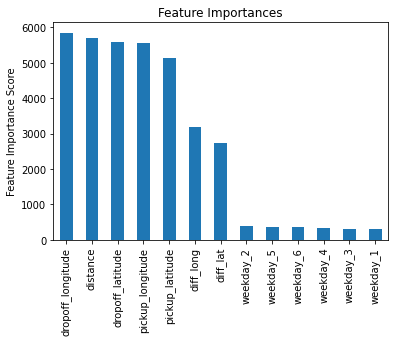

In [ ]:
xgb3 = XGBRegressor(
        learning_rate=0.15,
        n_estimators=1500,
        max_depth = 6,
        min_child_weight=5,
        gamma = 0.6,
        subsample = 1,
        colsample_bytree=0.9,
        reg_alpha=100,
        objective= 'reg:squarederror',
        nthread=6,
        scale_pos_weight=1,
        seed=27)

preds = modelfit(xgb3, X_train, X_test, y_train, predict=True)

In [ ]:
submission = pd.read_csv(PATH + '/sample_submission.csv')
submission['fare_amount'] = predictions
submission.to_csv('sub.csv', index=False)